# MPAS Head and Salt Budgets

***

In [1]:
import numpy as np
import xarray as xr
from datetime import datetime
from matplotlib import pyplot as plt
from cartopy import crs, feature
from tqdm import tqdm

plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

***

In [2]:
# Define run and load example results file
restartyears = [11, 21]
prefix = 'timeMonthly_avg_'
resultspath = '/pscratch/sd/b/bmoorema/run_001_062/'
runID = '20210421_sim7_CORE_60to30E2r2.mpaso'
filename = resultspath + runID + '.hist.am.timeSeriesStatsMonthly.0001-01-01.nc'
ds = xr.open_dataset(filename)

***

### Budget variables

In [3]:
# Budget variables (missing frazil)
namesT = {
    'HorzAdvT'  : 'activeTracerHorizontalAdvectionTendency_temperatureHorizontalAdvectionTendency',
    'VertAdvT'  : 'activeTracerVerticalAdvectionTendency_temperatureVerticalAdvectionTendency',
    'HorzMixT'  : 'activeTracerHorMixTendency_temperatureHorMixTendency',
    'VertMixT'  : 'activeTracerVertMixTendency_temperatureVertMixTendency',
    'SurfT'     : 'activeTracerSurfaceFluxTendency_temperatureSurfaceFluxTendency',
    'NonlocalT' : 'activeTracerNonLocalTendency_temperatureNonLocalTendency',
    'SWT'       : 'temperatureShortWaveTendency',
}

namesS = {
    'HorzAdvS'  : 'activeTracerHorizontalAdvectionTendency_salinityHorizontalAdvectionTendency',
    'VertAdvS'  : 'activeTracerVerticalAdvectionTendency_salinityVerticalAdvectionTendency',
    'HorzMixS'  : 'activeTracerHorMixTendency_salinityHorMixTendency',
    'VertMixS'  : 'activeTracerVertMixTendency_salinityVertMixTendency',
    'SurfS'     : 'activeTracerSurfaceFluxTendency_salinitySurfaceFluxTendency',
    'NonlocalS' : 'activeTracerNonLocalTendency_salinityNonLocalTendency',
}

varNames = namesT | namesS

Temperature budget variables

In [4]:
# Temperature budget
for varName, fullName in namesT.items():
    attrs = ds[prefix + fullName].attrs
    long_name, units = attrs['long_name'], attrs['units']
    print(f'{varName:10s} {long_name:73s} {units}')

HorzAdvT   potential temperature tendency due to horizontal advection                degrees Celsius per second
VertAdvT   potential temperature tendency due to vertical advection                  degrees Celsius per second
HorzMixT   potential temperature tendency due to horizontal mixing (including Redi)  degrees Celsius per second
VertMixT   potential temperature tendency due to vertical mixing                     degrees Celsius per second
SurfT      potential temperature tendency due to surface fluxes                      degrees Celsius per second
NonlocalT  potential temperature tendency due to kpp non-local flux                  degrees Celsius per second
SWT        potential temperature tendency due to penetrating shortwave               degrees Celsius per second


Salinity budget variables

In [5]:
# Salinity budget
for varName, fullName in namesS.items():
    attrs = ds[prefix + fullName].attrs
    long_name, units = attrs['long_name'], attrs['units']
    print(f'{varName:10s} {long_name:60s} {units}')

HorzAdvS   salinity tendency due to horizontal advection                PSU per second
VertAdvS   salinity tendency due to vertical advection                  PSU per second
HorzMixS   salinity tendency due to horizontal mixing (including Redi)  PSU per second
VertMixS   salinity tendency due to vertical mixing                     PSU per second
SurfS      salinity tendency due to surface fluxes                      PSU per second
NonlocalS  salinity tendency due to kpp non-local flux                  PSU per second


***

### Budget calculation

Get coordinates and subdomain

In [21]:
# Get subdomain
bbox = [-100, 45, 30, 85]
filename = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
ds = xr.open_dataset(filename)
lons = np.rad2deg(ds.lonCell.values)
lats = np.rad2deg(ds.latCell.values)
lons = np.where(lons > 180, lons - 360, lons)
depth = ds.refBottomDepth.values
subdomain, = np.where(
    (lons > bbox[0]) & (lons < bbox[1]) &
    (lats > bbox[2]) & (lats < bbox[3])
)
lons, lats = lons[subdomain], lats[subdomain]

LHS from restarts

In [9]:
# Get LHS from restarts
lhsT, lhsS = [], []
for year in restartyears:
    filename = resultspath + f'{runID}.rst.{year:04d}-01-01_00000.nc'
    ds = xr.open_dataset(filename)
    lhsT.append(ds['temperature'][0, ...].values[subdomain, ...])
    lhsS.append(ds['salinity'][0, ...].values[subdomain, ...])
lhsT = lhsT[1] - lhsT[0]
lhsS = lhsS[1] - lhsS[0]

RHS from budget tendency variables

In [11]:
# Get RHS by time-integrating between restarts
data = {varName: 0 for varName in varNames}
for year in tqdm(range(*restartyears)):
    for month in range(1, 13):
        filename = resultspath + f'{runID}.hist.am.timeSeriesStatsMonthly.{year:04d}-{month:02d}-01.nc'
        ds = xr.open_dataset(filename)
        for varName, fullName in varNames.items():
            data[varName] = data[varName] + ds[prefix + fullName][0, ...].values[subdomain, ...]

100%|██████████| 10/10 [02:52<00:00, 17.29s/it]


Calculate residual (frazil)

In [32]:
# Total seconds
nsec = 10 * 365 * 86400

# Temperature budget
rhsT = 0
for varName, fullName in namesT.items():
    rhsT = rhsT + data[varName]
resT = lhsT - rhsT * nsec

# Salinity budget
rhsS = 0
for varName, fullName in namesS.items():
    rhsS = rhsS + data[varName]
resS = lhsS - rhsS * nsec

***

### Visualization

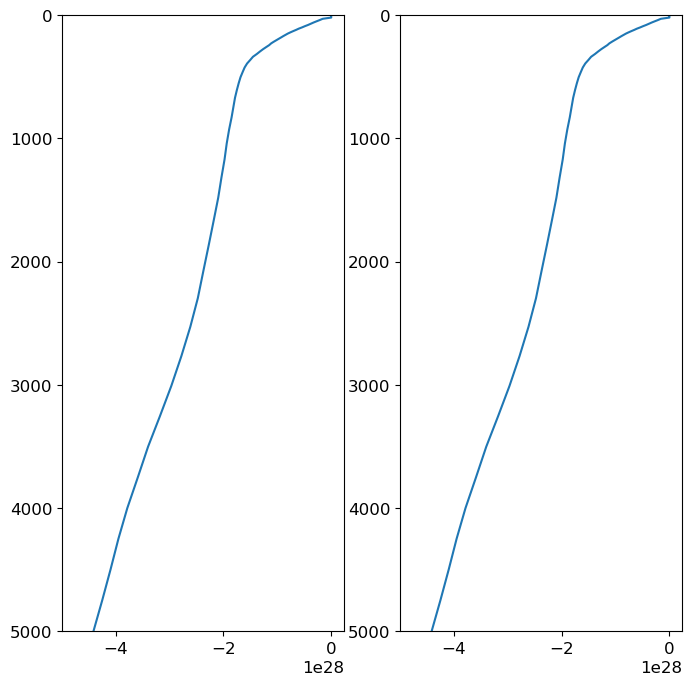

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
for ax, res in zip(axs, [resT, resS]):
    ax.plot(res.mean(axis=0), depth)
    ax.set_ylim(5000, 0)